In [338]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [339]:
orig_img = cv2.imread("assets/images/photo_2025-05-27_17-01-25.jpg")
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
seg_mask = cv2.imread("assets/results/resnet34/photo_2025-05-27_17-01-25.png")
seg_mask = cv2.cvtColor(seg_mask, cv2.COLOR_BGR2GRAY)

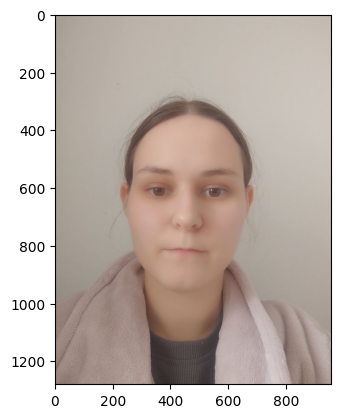

In [340]:
plt.imshow(orig_img)

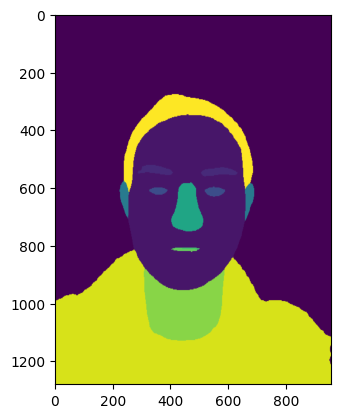

In [341]:
plt.imshow(seg_mask)

In [342]:
np.unique(seg_mask)

array([ 0,  1,  2,  4,  7, 10, 12, 13, 14, 16, 17], dtype=uint8)

In [343]:
seg_mask_mouth = seg_mask.copy()
seg_mask_face = seg_mask.copy()
seg_mask_eyes = seg_mask.copy()

seg_mask_eyes[(seg_mask_eyes!=4) & (seg_mask_eyes!=5)] = 0

seg_mask_mouth[(seg_mask_mouth!=11) & (seg_mask_mouth!=12) & (seg_mask_mouth!=13)] = 0

seg_mask_face[seg_mask_face!=1] = 0


In [344]:
def find_part_rect(part_seg_mask):
    cnt, _ = cv2.findContours(part_seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(cnt) < 1:
        return np.asarray([0,0,0,0])
    print(cnt[0].min(axis=0), cnt[0].max(axis=0))
    return np.asarray(cv2.boundingRect(cnt[0][:,0,:]))

def left_right_eye(seg_mask_eyes):
    cnt, _ = cv2.findContours(seg_mask_eyes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(cnt) == 2:
        eyes_rects = [np.asarray(cv2.boundingRect(cnt[i][:,0,:])) for i in range(2)]
        eyes_rects = np.sort(eyes_rects, axis=0)
        print(eyes_rects)
        return eyes_rects
    
    elif len(cnt) == 1:
        eye_rect = np.asarray(cv2.boundingRect(cnt[0][:, 0, :]))
        print("Found 1 eye:", eye_rect)
        return eye_rect, None

    else:
        print(f"Found {len(cnt)} eyes — unsupported number.")
        return None, None

In [345]:
left_eye_rect, right_eye_rect = left_right_eye(seg_mask_eyes)
mouth_rect = find_part_rect(seg_mask_mouth)
face_rect = find_part_rect(seg_mask_face)

[[326 597  63  25]
 [518 600  70  35]]
[[402 808]] [[499 822]]
[[253 347]] [[658 954]]


In [346]:
img = orig_img.copy()

if left_eye_rect is not None:
    img = cv2.rectangle(img.copy(), left_eye_rect[0:2],  left_eye_rect[0:2]+left_eye_rect[2:4],
                        color=(255,255,0), thickness=6)

if right_eye_rect is not None:
    img = cv2.rectangle(img.copy(), right_eye_rect[0:2],  right_eye_rect[0:2]+right_eye_rect[2:4],
                        color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), mouth_rect[0:2],  mouth_rect[0:2]+mouth_rect[2:4],
                    color=(255,0,255), thickness=6)

img = cv2.rectangle(img.copy(), face_rect[0:2],  face_rect[0:2]+face_rect[2:4],
                    color=(0,0,255), thickness=6)

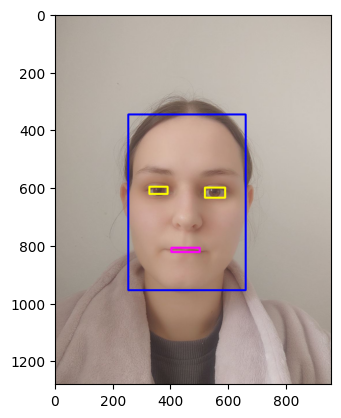

In [347]:
plt.imshow(img)

In [348]:
def adjust_eye_rects_by_face(face_rect, left_eye_raw_rect, right_eye_raw_rect, img_shape):
    fx, fy, fw, fh = face_rect
    img_h, img_w = img_shape[:2]

    target_eye_width = int(fw / 5.0)
    target_eye_height = int(target_eye_width * 0.6)

    center_face_x = fx + fw // 2
    center_face_y = fy + fh // 2

    def adjust_eye(raw_rect):
        if raw_rect is None or raw_rect[2] <= 0 or raw_rect[3] <= 0:
            return None
        x, y, w, h = raw_rect
        cx = x + w // 2
        cy = y + h // 2
        ax = max(0, cx - target_eye_width // 2)
        ay = max(0, cy - target_eye_height // 2)
        return np.array([
            ax,
            ay,
            min(target_eye_width, img_w - ax),
            min(target_eye_height, img_h - ay)
        ])

    adjusted_left_eye = adjust_eye(left_eye_raw_rect)
    adjusted_right_eye = adjust_eye(right_eye_raw_rect)

    if adjusted_left_eye is not None and adjusted_right_eye is None:
        lx, ly, lw, lh = adjusted_left_eye
        center_lx = lx + lw // 2
        dist = center_face_x - center_lx
        mirror_cx = center_face_x + dist
        ax = max(0, mirror_cx - target_eye_width // 2)
        ay = ly
        adjusted_right_eye = np.array([
            ax,
            ay,
            min(target_eye_width, img_w - ax),
            min(target_eye_height, img_h - ay)
        ])

    elif adjusted_right_eye is not None and adjusted_left_eye is None:
        rx, ry, rw, rh = adjusted_right_eye
        center_rx = rx + rw // 2
        dist = center_rx - center_face_x
        mirror_cx = center_face_x - dist
        ax = max(0, mirror_cx - target_eye_width // 2)
        ay = ry
        adjusted_left_eye = np.array([
            ax,
            ay,
            min(target_eye_width, img_w - ax),
            min(target_eye_height, img_h - ay)
        ])

    if adjusted_left_eye is None and adjusted_right_eye is None:
        eye_y = fy + int(fh * 0.3)
        left_eye_x = fx + int(fw * 0.25) - target_eye_width // 2
        right_eye_x = fx + int(fw * 0.75) - target_eye_width // 2

        adjusted_left_eye = np.array([
            max(0, left_eye_x),
            max(0, eye_y),
            min(target_eye_width, img_w - left_eye_x),
            min(target_eye_height, img_h - eye_y)
        ])

        adjusted_right_eye = np.array([
            max(0, right_eye_x),
            max(0, eye_y),
            min(target_eye_width, img_w - right_eye_x),
            min(target_eye_height, img_h - eye_y)
        ])

    return adjusted_left_eye, adjusted_right_eye


In [349]:
img_height, img_width = img.shape[:2]

left_eye_rect_full, right_eye_rect_full = adjust_eye_rects_by_face(
    face_rect, left_eye_rect, right_eye_rect, img.shape
)


In [350]:
img = orig_img.copy()
img = cv2.rectangle(img.copy(), left_eye_rect_full[0:2],  left_eye_rect_full[0:2]+left_eye_rect_full[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), right_eye_rect_full[0:2],  right_eye_rect_full[0:2]+right_eye_rect_full[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), mouth_rect[0:2],  mouth_rect[0:2]+mouth_rect[2:4],
                    color=(255,0,255), thickness=6)

img = cv2.rectangle(img.copy(), face_rect[0:2],  face_rect[0:2]+face_rect[2:4],
                    color=(0,0,255), thickness=6)

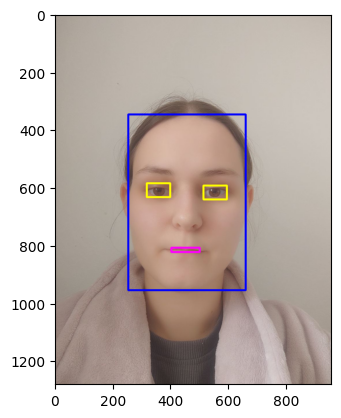

In [351]:
plt.imshow(img)